In [1]:
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv(r"C:\Users\asus\Desktop\pro1\6th project\AAPL_daily_update.csv")

In [3]:
data.head() 

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-09-10,53.465000,54.195000,52.927502,54.174999,53.642761,127111600
1,2019-09-11,54.517502,55.927502,54.432499,55.897499,55.348343,177158400
2,2019-09-12,56.200001,56.605000,55.715000,55.772499,55.224567,128906800
3,2019-09-13,55.000000,55.197498,54.255001,54.687500,54.150230,159053200
4,2019-09-16,54.432499,55.032501,54.389999,54.974998,54.434902,84632400


In [4]:
data.shape

(254, 7)

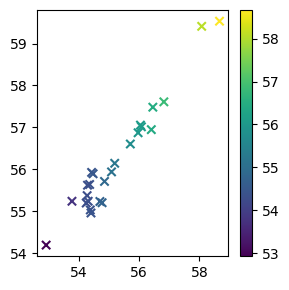

In [5]:
plt.figure(figsize=(3,3))
scatter = plt.scatter(data.Low[:25],data.High[:25],marker='x',c =data.Low[:25], cmap='viridis')
plt.colorbar(scatter)
plt.tight_layout()

In [6]:
df = data.Close

In [7]:
df

0       54.174999
1       55.897499
2       55.772499
3       54.687500
4       54.974998
          ...    
249    120.879997
250    120.959999
251    112.820000
252    117.320000
253    114.274597
Name: Close, Length: 254, dtype: float64

In [8]:
x_data =[]
y_data = []
timestep = 9

for i in range(0,len(df)-timestep):
    [x_data.append(df[i:i+timestep].values)]
    [y_data.append(df[i+timestep])]
    

In [9]:
x_data = np.array(x_data)
y_data = np.array(y_data)

In [10]:
x_data.shape, y_data.shape

((245, 9), (245,))

In [11]:
x_train,x_test,y_train,y_test = train_test_split(x_data,y_data,test_size = 0.3)

In [12]:
x_train.shape,  x_test.shape

((171, 9), (74, 9))

In [13]:
y_train.shape, y_test.shape

((171,), (74,))

In [14]:
normalisex = MinMaxScaler()
normalisey = MinMaxScaler()

x_train_norm = normalisex.fit_transform(x_train)
x_test_norm = normalisex.transform(x_test)

y_train_norm = normalisey.fit_transform(y_train.reshape(-1,1))
y_test_norm = normalisey.transform(y_test.reshape(-1,1))

x_train_tens = torch.tensor(x_train_norm,dtype=torch.float32)
x_test_tens = torch.tensor(x_test_norm,dtype=torch.float32)
x_train_tens = x_train_tens.reshape(x_train_tens.shape[0],1,x_train_tens.shape[1])
x_test_tens = x_test_tens.reshape(x_test_tens.shape[0],1,x_test_tens.shape[1])


y_train_tens = torch.tensor(y_train_norm, dtype=torch.float32).reshape(171, 1, 1)
y_test_tens = torch.tensor(y_test_norm, dtype=torch.float32).reshape(-1, 1, 1)

In [15]:
x_train[:2],x_train_norm[:2],x_train_tens.shape, y_train_tens.shape

(array([[73.412498, 75.087502, 74.357498, 74.949997, 74.597504, 75.797501,
         77.407501, 77.582497, 79.239998],
        [73.290001, 74.389999, 75.157501, 75.934998, 77.532501, 78.752502,
         77.852501, 76.912498, 77.385002]]),
 array([[0.26340973, 0.2865169 , 0.2671871 , 0.2573972 , 0.25286067,
         0.26790813, 0.28820843, 0.29040246, 0.31118357],
        [0.2617108 , 0.27684145, 0.27790813, 0.26974676, 0.2896643 ,
         0.3049626 , 0.29378767, 0.28200227, 0.28792635]]),
 torch.Size([171, 1, 9]),
 torch.Size([171, 1, 1]))

In [16]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lay1 = nn.LSTM(input_size=9,hidden_size=2)
        self.lay2 = nn.LSTM(2,4)
        self.lay3 = nn.LSTM(4,1)
        #self.lay4 = nn.Linear(2,1)
    def forward(self, inputs):
        out,_ = self.lay1(inputs)
        out,_ = self.lay2(out)
        out,_ = self.lay3(out)
        #out = self.lay4(out[:,-1,:])
        return out
        
model = LSTM()
loss = nn.MSELoss()
optimiser = optim.Adam(model.parameters(),lr = 0.001)

for i in range(1000):
    model.train()
    optimiser.zero_grad()
    outputs = model.forward(x_train_tens)
    lozz = loss(outputs,y_train_tens)
    lozz.backward()
    optimiser.step()
    

In [17]:
model.eval()
with torch.no_grad():
    pred = model(x_test_tens)

In [18]:
outp = outputs.detach().numpy().reshape(-1,1)
pred = pred.detach().numpy().reshape(-1,1).astype('float64')

In [19]:
from sklearn.metrics import mean_absolute_error

In [20]:
re = normalisey.inverse_transform(pred)

In [21]:
re[:5]

array([[52.84745171],
       [61.10529718],
       [67.49598331],
       [71.75186613],
       [74.39589708]])

In [22]:
score = mean_absolute_error(y_test,re)
train_score = score = mean_absolute_error(y_train,outp)

In [23]:
score, train_score

(78.9634178150307, 78.9634178150307)